# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [2]:
!pip install numpy==1.13.3

    100% |████████████████████████████████| 17.0MB 2.5MB/s eta 0:00:01
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1


In [ ]:
!pip install prompt-toolkit==1.0.15

In [3]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [8]:
import torch.nn as nn

def q_model (state_size, action_size, seed):
    hidden_size = 64
    return nn.Sequential(
        nn.Linear(state_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, action_size))

Replay buffer class with random sampling

In [9]:
import torch
import random
from collections import deque, namedtuple

class ReplayBuffer:
    """ Fixed sized buffer to store experience tuples """

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """
        Initialize Replay Buffer object.
        """

        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])

    def __len__(self):
        """
        return the current buffer memory size.
        """
        return len(self.memory)

    def add(self, state, action, reward, next_state, done):
        self.memory.append(
            self.experience(state, action, reward, next_state, done)
        )
    
    def sample(self):
        """
        return a randomly selected experience from the buffer.
        """
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device) 
        done = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, done)


RL agent definition

In [17]:
import torch.optim as optim
import torch.nn.functional as F

# replay buffer size
BUFFER_SIZE = int(1e5)
# minibatch size
BATCH_SIZE = 64
# how often to update the network
NET_UPDATE = 4
# discount factor
GAMMA = 0.99
# for soft update of target parameters
TAU = 5e-3
# Learning rate
LR = 1e-3

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class Agent():
    """
    Interacts and learns from the environment.
    """
    def __init__(self, state_size, action_size, seed):
        """
        Object initialization.
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.q_local = q_model(state_size,action_size, seed).to(device)
        self.q_target = q_model(state_size,action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_local.parameters(), lr=LR)

        self.buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0

    def soft_update(self):
        """
        Soft update model parameters.
        """
        for target_p, local_p in zip(self.q_target.parameters(), self.q_local.parameters()):
            target_p.data.copy_(TAU * local_p.data + (1 - TAU)*target_p.data)

    def learn(self):
        """
        Update value parameters using given batch of experience tuples.
        """
        states, actions, rewards, next_states, dones = self.buffer.sample()

        q_targets_next  =  self.q_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + (GAMMA * q_targets_next * (1 - dones))
        q_pred = self.q_local(states).gather(1, actions)
        loss = F.mse_loss(q_pred, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update target network
        self.soft_update()

    def step(self, action, state, reward, next_state, done):
        """
        Learn from the experience.
        """
        self.buffer.add(action, state, reward, next_state, done)

        self.t_step = (self.t_step + 1) % NET_UPDATE

        if self.t_step == 0:
            if len(self.buffer) > BATCH_SIZE:
                self.learn()
    
    def act(self, state, eps=0.0):
        """
        Returns actions for given state as per current policy.
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.q_local.eval()
        with torch.no_grad():
            action = self.q_local(state)
        
        self.q_local.train()
        if random.random() > eps:
            action = np.argmax(action.cpu().data.numpy())
        else:
            action = np.random.choice(np.arange(self.action_size))
        return action



RL agent training fuction.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def dqn(num_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """
    Deep Q-Learning
    """
    # list containing scores from each episode.
    scores = []
    # last 100 scores.
    scores_recent = deque(maxlen=100)
    # initialize epsilon.
    eps = eps_start

    for i_episode in range(1, num_episodes + 1):
        env_info = env.reset(train_mode=True)[brain_name]

        # get the initial state
        state = env_info.vector_observations[0]

        score = 0
        # consider episodic with 100 steps.
        for i_t in range(max_t):
            # select an action.
            action = agent.act(state, eps)
            # send the action to the environment.
            env_info = env.step(action)[brain_name]
            # get the next state.
            next_state = env_info.vector_observations[0]
            # get the reward.
            reward = env_info.rewards[0]
            # see if the episode has finished.
            done = env_info.local_done[0]
            # sample and learn step of Q-Learning
            agent.step(state, action, reward, next_state, done)
            # update score.
            score += reward
            # upward the next state step.
            state = next_state
            # finis if the episode is done.
            if done:
                break
        
        # store score
        scores.append(score)
        scores_recent.append(score)

        # decrease epsilon
        eps = max(eps_end, eps * eps_decay)

        print('\rEpisode {}\tAverage_Score: {:-2f}'.format(i_episode, np.mean(scores_recent)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_recent)))
        
        if np.mean(scores_recent)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_recent)))
            torch.save(agent.q_local.state_dict(), 'checkpoint.pth')
            break
    
    return scores


Main fuction.

Episode 100	Average Score: 4.210000
Episode 200	Average Score: 11.540000
Episode 300	Average Score: 12.010000
Episode 400	Average Score: 12.290000
Episode 480	Average_Score: 13.020000
Environment solved in 380 episodes!	Average Score: 13.02


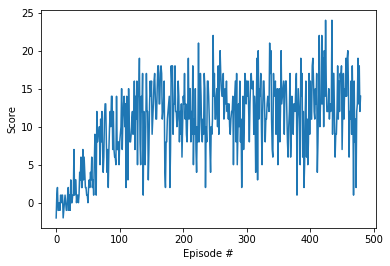

In [18]:
agent = Agent(state_size, action_size, seed=0)
scores = dqn(2000, eps_decay=0.925)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
env.close()